### Decision Tree (DecisionTree.ipynb)

Train a Decision Tree using a ChoiceMaker to decide when to stop branching.

Goal: See how a ChoiceMaker performs when applied to a novel area. Having the lowest error 
compared to naive methods would be great.

Comparison: We compare against a naive way of making a decision tree algorithm
private, as well as another method described in a sketchy paper. I implemented
everything.

Current Results: The Choicemaker seems to be competitive with the two other methods
sometimes. We definitely need more data supporting this claim for a final submission.

Improvement 1: figure out a way to make epsilon equal to 1.0 always.
Improvement 2: simplify the error computations.


In [1]:
import DPrivacy as dp
from ChoiceMaker import DTChoice
from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier
#import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline
import pickle
import collections
import numpy as np
import pandas as pd
from decision_tree import CoefCM, Leaf, Split, DB, DBMetas, PDTree
import copy
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [94]:
#Retrain flags!
rerun_gen_training_data = False
rerun_train_cms = False
rerun_exps = [False, False, False, False, True, False, False]

In [3]:
tree_algs = {'leaf': Leaf(), 'split': Split()}
"""

This competitor algorithm appears in:

Sam Fletcher and Md Zahidul Islam. Decision Tree Classification with Differential Privacy: A Survey.
In CoRR, volume = abs/1611.01919, 2016

This algorithm was chosen because it is "subsumed" by Jostle, meaning its code can be represented internally
by Jostle's trees.
"""
fried_cm = CoefCM([1, 0, 1, 0, -1, 0, -1], np.log(1.414))

### DATASETS

In [4]:
adult = pickle.load(open('decision_tree_data/adult.pkl', 'rb'))

nurs = pd.read_csv('../datasets/nursery.data', header=None)
nurs = nurs.apply(lambda x: x.astype('category'))

default = pickle.load(open('decision_tree_data/default.pkl', 'rb'))

loan = pd.read_csv('../datasets/student-loan.csv')
loan = loan.apply(lambda x: x.astype('category'))

lending = pickle.load(open('decision_tree_data/lending.pkl', 'rb'))

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.core' is private. Use 'pandas.Categorical'
  """Entry point for launching an IPython kernel.


In [5]:
letter = pickle.load(open('decision_tree_data/letter.pkl', 'rb'))
magicdb = pickle.load(open('decision_tree_data/magic.pkl', 'rb'))

In [6]:
print([len(adult[c].cat.categories) for c in adult])
print([len(nurs[c].cat.categories) for c in nurs])
print([len(default[c].cat.categories) for c in default])
print([len(loan[c].cat.categories) for c in loan])
print([len(lending[c].cat.categories) for c in lending])
print([len(letter[0][c].cat.categories) for c in letter[0]])
print([len(magicdb[c].cat.categories) for c in magicdb])

[7, 9, 10, 16, 16, 7, 15, 6, 5, 2, 2, 2, 4, 5, 2]
[3, 5, 4, 4, 3, 2, 3, 3, 5]
[10, 2, 7, 4, 7, 11, 11, 11, 11, 10, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2]
[10, 2, 2, 8, 7, 16, 2, 2, 2]
[2, 4, 4, 6, 8, 6, 10, 10, 5, 2, 3, 7, 5, 4]
[12, 16, 14, 11, 13, 13, 13, 16, 13, 12, 13, 14, 12, 9, 12, 14, 5]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2]


### Experiments

In [7]:
#database generation infrastructure
exec(open('d_tree_dbinfra.py').read())

In [8]:
eps_vals = np.array([0.05, 0.1, 0.25, 0.5, 0.8])
def get_test(db, prng, eps_vals):
    dbs = []
    for i in range(0, 3):
        for e in eps_vals:
            dbs.append(get_train_dbs(db, e, prng))
    return dbs

In [9]:

#directory = '/longterm/jimola/data_train.pkl'
directory = 'decision_tree_metadata/training_dbs.pkl'
if rerun_gen_training_data:
    prng=np.random.RandomState(12345)
    data_train = [get_test(db, prng, eps_vals) for db in \
                  [nurs, default, loan, adult, lending]]
    if rerun_save_training_data:
        pickle.dump(data_train, open(directory, 'wb'))
else:
    #These dbs take up a ton of memory. They are not on the github repo but they are in a directory on Matt's machine
    data_train = pickle.load(open(directory, 'rb'))

In [10]:
"""
Trains a choicemaker

Parameters:
info: list of (regrets, metafeatures, db) tuples. 
            db is actually not needed; could just be a metafeature list.
"""
def get_cm(info):
    regrets, X, datas = zip(*info)
    regrets = pd.concat([pd.DataFrame(r) for r in regrets], ignore_index=True)
    X = pd.concat([pd.DataFrame(r) for r in X], ignore_index=True)
    return DTChoice(X, DBMetas(), tree_algs, regrets=regrets)

if rerun_train_cms:
    cms = [get_cm(o) for o in data_train]
    mfs = [cm.X for cm in cms]
    regs = [cm.regrets for cm in cms]
    pickle.dump(mfs, open('decision_tree_metadata/data.pkl', 'wb'))
    pickle.dump(regs, open('decision_tree_metadata/regrets.pkl', 'wb'))
else:
    mfs = pickle.load(open('decision_tree_metadata/data.pkl', 'rb'))
    regs = pickle.load(open('decision_tree_metadata/regrets.pkl', 'rb'))
    cms = [ DTChoice(mfs[i], DBMetas(), tree_algs, regrets=regs[i]) for i in range(len(mfs))]

In [11]:
"""
A convenience method for taking training data in choicemakers and combining it into one choicemaker.
Used in my experiments for leave-one-out cross validation.

Parameters:
cms: list of choicemakers.
C, msl: parameters of the choicemaker's internal tree, but not super important as they can be set later.
"""
def combine_cms(cms, C=0, msl=1):
    Xs = pd.concat([cm.X for cm in cms], ignore_index=True)
    regs = pd.concat([cm.regrets for cm in cms], ignore_index=True)
    dt = DTChoice(Xs, DBMetas(), tree_algs, regrets=regs, C=0)
    dt.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=3)
    dt.retrain_model()
    return dt

In [12]:
"""
Tests a set of choicemakers on a test of databases and returns % classified correctly.
Parameters:
cm_list: list of choicemakers.
dbs: list of test dbs.
"""
def get_results(dbs, cm_list):
    budgets = [x.epsilon for x in dbs]
    ans = []
    for cm in cm_list:
        dt = PDTree()
        L = []
        for t in dbs:
            L.append( dt.fit_and_predict(t, cm) )
        for i in range(len(dbs)):
            dbs[i].epsilon = budgets[i]
        M = np.array([(L[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
        ans.append(M)
    return ans

In [13]:
#Reinitialize prng before the experiments so we can reproduce their exact runs
prng = np.random.RandomState(12345)

### Testing properties of different choicemakers:

In [14]:
# Prints basic stats about cm run on a db
def choicemaker_stats(db, cm, epsilon,D=4):
    testdb = copy.deepcopy(db)
    testdb_train = copy.deepcopy(db)
    if isinstance(cm, DTChoice):
        cm.algs['split'].numruns = 0
        cm.algs['leaf'].numruns = 0
    elif isinstance(cm, CoefCM):
        cm.leaf.numruns = 0
        cm.split.numruns = 0
    testdb.max_depth=D
    testdb_train.max_depth=D
    testdb_train.X_test = testdb_train.X
    testdb_train.y_test = testdb_train.y
    testdb.epsilon = 1.0
    testdb_train.epsilon = 1.0
    dt = PDTree()
    P_out = dt.fit_and_predict(testdb, cm)
    P_in = dt.fit_and_predict(testdb_train, cm)
    M_out = (P_out == testdb.y_test).mean()
    M_in = (P_in == testdb_train.y_test).mean()
    print("No. times maximum depth: %d" % dt.leaf.numruns)
    if isinstance(cm, DTChoice):
        print("No. times chose to split: %d" % cm.algs['split'].numruns)
        print("No. times chose to leaf: %d" % cm.algs['leaf'].numruns)
    elif isinstance(cm, CoefCM):
        print("No. times chose to split: %d" % cm.split.numruns)
        print("No. times chose to leaf: %d" % cm.leaf.numruns)
    print("In-sample score: %f" % M_in)
    print("Out-of-sample score: %f" % M_out)
    return M_out
def db_stats(i, db, epsilon,D=4):
    insample_cm = cms[i]
    insample_cm.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
    insample_cm.retrain_model()
    outsample_cm = combine_cms(cms[:i] + cms[(i+1):])
    outsample_cm.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
    outsample_cm.retrain_model()
    cm_list = [null_cm(0), null_cm(1), null_cm(2), outsample_cm, insample_cm, fried_cm]
    return [choicemaker_stats(db, C, epsilon) for C in cm_list]

In [15]:
def run_experiment(i, db, msl=10, md=4):
    insample_cm = cms[i]
    insample_cm.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
    insample_cm.retrain_model()
    outsample_cm = combine_cms(cms[:i] + cms[(i+1):])
    outsample_cm.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
    outsample_cm.retrain_model()
    if rerun_exps[i]:
        res = get_results(db, [null_cm(0), null_cm(1), null_cm(2), outsample_cm, insample_cm, fried_cm])
        pickle.dump(res, open('decision_tree_results/experiment%d.pkl' % i, 'wb'))
    else:
        res = pickle.load(open('decision_tree_results/experiment%d.pkl' % i, 'rb'))
    return res

In [78]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey']
names = ['Naive0','Naive1', 'Naive2','Jostle,\nIn-samp','Jostle,\nOut-samp.','Competitor\nAlg.']

def do_graphs(res):
    res = np.array(res)
    stds = res.std(axis=1)
    errors = 1.0-res.mean(axis=1)
    patches = [mpatches.Patch(color=c) for c in colors]
    fig, axis = plt.subplots()
    axis.set_xticks(range(len(colors)))
    axis.set_xticklabels(names)
    axis.set_xlabel('Algorithm')
    axis.set_ylabel('Mean Error')
    #axis.legend(handles=patches, labels=['Alg1', 'Alg2', 'Jostle'])
    axis.set_title('Mean Performance for 3 Stopping Criteria')
    return axis.bar(range(len(colors)), errors, color=colors, yerr=stds)

### Experiment 0

In [16]:
"""
Format for the experiments:
outsample_cm{i} is the choicemaker for all databases from which the test database are not generated, 
        a sort of leave-one-out cross-validation.
insample_cm{i} is the complement of big_cm{i}, so the same database is used for both training and
        testing data. This is to serve as a comparison.
I set the depth of the internal tree to 4,
    and min. samples per leaf (see sklearn documentation) to 10, somewhat arbitrarily.
I test using epsilon=0.25 and run 5 trials for each experiment on each database. This could certainly be increased
as the error bars have high noise.
"""
epsilon = 0.25
num_trials = 10

In [17]:
nursdata = [get_test_dbs(nurs, epsilon, prng) for i in range(0, num_trials)]
res0 = run_experiment(0, nursdata)

<BarContainer object of 6 artists>

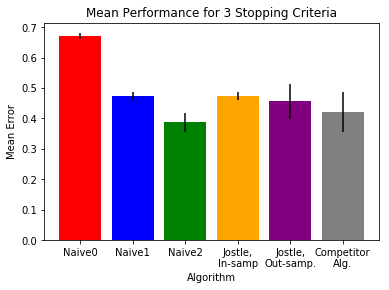

In [79]:
do_graphs(res0)

### Experiment 1

In [24]:
defaultsdata = [get_test_dbs(default, epsilon, prng) for i in range(0, num_trials)]
res1 = run_experiment(1, defaultsdata)

<BarContainer object of 6 artists>

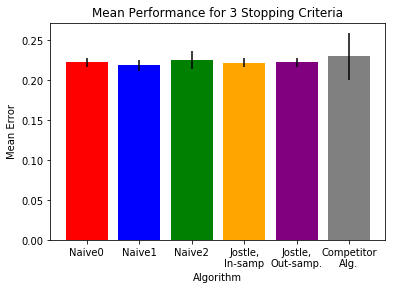

In [80]:
do_graphs(res1)

### Experiment 2

In [29]:
#This experiment is not great
loandata = [get_test_dbs(loan, epsilon, prng) for i in range(num_trials)]
res2 = run_experiment(2, loandata)

<BarContainer object of 6 artists>

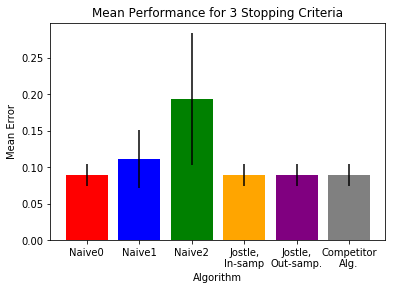

In [81]:
#db_stats(2, loandata[0], 0.25, 4)
do_graphs(res2)

### Experiment 3

In [85]:
adultdata = [get_test_dbs(adult, epsilon, prng) for i in range(num_trials)]
res3 = run_experiment(3, adultdata)

<BarContainer object of 6 artists>

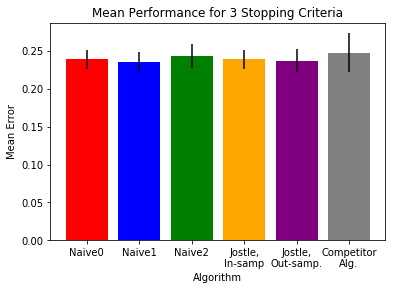

In [87]:
do_graphs(res3)

### Experiment 4

In [95]:
lendingdata = [get_test_dbs(lending, epsilon, prng) for x in range(num_trials)]
res4 = run_experiment(4, lendingdata)

<BarContainer object of 6 artists>

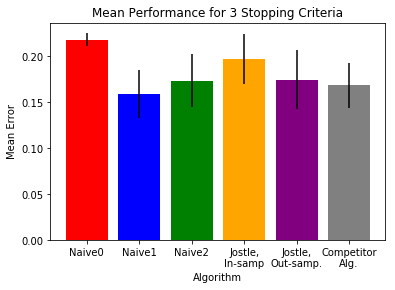

In [97]:
do_graphs(res4)

In [41]:
letterdb = [get_test_dbs(letter[0], epsilon, prng) for x in range(num_trials)]
res5 = run_experiment(5, letterdb)

<BarContainer object of 6 artists>

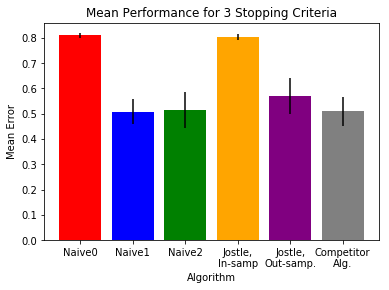

In [92]:
do_graphs(res5)

In [43]:
magic = [get_test_dbs(magicdb, epsilon, prng) for x in range(num_trials)]
res6 = run_experiment(6, magic)

<BarContainer object of 6 artists>

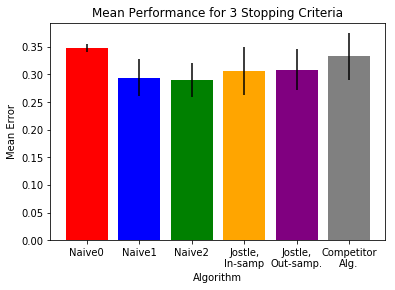

In [93]:
do_graphs(res6)